# <span style="font-family:Courier">scikit-learn</span> Machine Learning Approaches  

#### Welcome to Notebook 2 in the IceCube AI Exploration Series  

#### <p> In this notebook, we explore the basic machine learning tools provided in scikit-learn. Seasoned AI developers may know that these methods are not suitable for reconstructing IceCube neutrino event directions based on the type of data provided.  But that is what we want!  This series both demonstrates how common AI methods are can be suitable or (very) not suitable for this task, teaching newcomers and experts alike in how these tools are utilized. </p>

#### Tools we cover: <span style="font-family:Courier">train_test_split, cross_val_score, mean_absolute_error, make_scorer, RandomForestRegressor, MultiOutputRegressor</span>

#### Topics we cover: Data Splitting, Training, Decision Trees, Random Forests, Regressors, Cross-Validation, Multi-Output Regressors




***


#### First step is always to prepare our tools: install and import necessary packages.

In [26]:
''' Install necessary packages '''

%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install pyarrow        ### pyarrow and fastparquet are new to me: these are necessary for loading parquet file data
%pip install fastparquet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import csv



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note

***

#### Next, we're going to load the event data with Pandas and see what it looks like

In [27]:
''' Load the data '''

datapath = '../../IceCube_Training_Data/'                                                   ### Adjust your path to match where you are keeping the parquet files
batch_list = [pd.read_parquet(datapath+'batch_'+str(i)+'.parquet') for i in range(1,6)]     ### I renamed the parquet files so I could easily loop over them and aggregate the events
rawdata = pd.concat(batch_list)

''' Let's see how many unique events we get out of 5 batch files: '''
events = rawdata.index.drop_duplicates()
print('Indices of unique events:')
print(events)
print('\n')

print('First rows of total dataframe:')
print(rawdata.head())
print('\n')

Indices of unique events:
Index([       24,        41,        59,        67,        72,        77,
              79,        82,       121,       127,
       ...
       331932694, 331932700, 331932728, 331932770, 331932779, 331932801,
       331932836, 331932852, 331932854, 331932899],
      dtype='int64', name='event_id', length=1000000)


First rows of total dataframe:
          sensor_id  time  charge  auxiliary
event_id                                    
24             3918  5928   1.325       True
24             4157  6115   1.175       True
24             3520  6492   0.925       True
24             5041  6665   0.225       True
24             2948  8054   1.575       True




In [4]:

rawdata_meta = pd.read_parquet('../../train_meta.parquet')
rawdata_meta = rawdata_meta.loc[rawdata_meta['event_id'].isin(events)]
print(rawdata_meta.head())


   batch_id  event_id  first_pulse_index  last_pulse_index   azimuth    zenith
0         1        24                  0                60  5.029555  2.087498
1         1        41                 61               111  0.417742  1.549686
2         1        59                112               147  1.160466  2.401942
3         1        67                148               289  5.845952  0.759054
4         1        72                290               351  0.653719  0.939117


In [5]:

merged_data = pd.merge(rawdata, rawdata_meta, on='event_id')
print(merged_data.head())


   event_id  sensor_id  time  charge  auxiliary  batch_id  first_pulse_index   
0        24       3918  5928   1.325       True         1                  0  \
1        24       4157  6115   1.175       True         1                  0   
2        24       3520  6492   0.925       True         1                  0   
3        24       5041  6665   0.225       True         1                  0   
4        24       2948  8054   1.575       True         1                  0   

   last_pulse_index   azimuth    zenith  
0                60  5.029555  2.087498  
1                60  5.029555  2.087498  
2                60  5.029555  2.087498  
3                60  5.029555  2.087498  
4                60  5.029555  2.087498  


In [6]:
# Aggregate the data by 'event_id'
aggregated_data = merged_data.groupby('event_id').agg({
    'zenith': 'mean',
    'azimuth': 'mean',
    'sensor_id': 'count',   # number of sensors triggered
    'time': ['min', 'max'],  # earliest and latest trigger time
    'charge': ['min', 'max', 'mean']  # minimum, maximum, and average charge
})

# Flatten the column names
aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]


print(aggregated_data.head())


          zenith_mean  azimuth_mean  sensor_id_count  time_min  time_max   
event_id                                                                   
24           2.087498      5.029555               61      5928     19031  \
41           1.549686      0.417742               51      6469     17230   
59           2.401942      1.160466               36      6601     15362   
67           0.759054      5.845952              142      6751     27144   
72           0.939117      0.653719               62      6083     17654   

          charge_min  charge_max  charge_mean  
event_id                                       
24             0.175       3.975     0.991393  
41             0.225       1.875     0.907353  
59             0.175       2.625     0.922222  
67             0.125       5.125     0.927817  
72             0.125       1.675     0.899194  


In [7]:
''' Starting with the basics '''

X = aggregated_data.drop(['zenith_mean', 'azimuth_mean'], axis=1)
y = aggregated_data[['zenith_mean', 'azimuth_mean']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=117)

# Train the multi-output random forest regressor

# We test multiple estimator values of the random forest and plot the score

predictions = []
estimator_number = np.concatenate([np.array([1]),np.arange(5,55,5)])
for i in estimator_number:
    print('Starting model '+str(i)+' of '+str(len(estimator_number)))
    rf = RandomForestRegressor(n_estimators=i, random_state=117, verbose=1)
    mor = MultiOutputRegressor(rf)
    mor.fit(X_train, y_train)
    predictions.append(mor.predict(X_test))





Starting model 1 of 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 5 of 11


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 10 of 11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   58.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 15 of 11


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 20 of 11


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 25 of 11


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 30 of 11


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 35 of 11


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 40 of 11


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting model 45 of 11


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.5s finished


Starting model 50 of 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.3s finished


In [8]:


def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''

    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))


def avg_angular_dist_score(y_true, y_pred):
    scores = []
    for i in range(len(y_true)):
        az_true, zen_true = y_true.iloc[i][:2]
        az_pred, zen_pred = y_pred[i][:2]
        score = angular_dist_score(az_true, zen_true, az_pred, zen_pred)
        scores.append(score)
    return np.mean(scores)








In [9]:

scores = []

for model in predictions:
    model_scores = []
    print('Scoring new model.')
    for event in range(len(model)):
        model_scores.append(angular_dist_score( y_test['zenith_mean'].iloc[event], y_test['azimuth_mean'].iloc[event], model[event][0],model[event][1]))
    scores.append(model_scores)




Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.


Text(0.5, 1.0, 'RandomForestRegressor Scores')

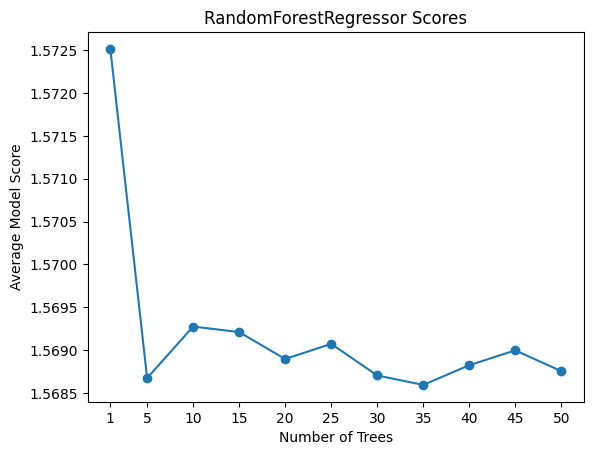

In [10]:
plt.plot(estimator_number,np.mean(np.array(scores), axis=1),marker='o')
plt.xticks([int(i) for i in estimator_number])
plt.xlabel('Number of Trees')
plt.ylabel('Average Model Score')
plt.title('RandomForestRegressor Scores')

In [11]:
with open('RandomForestRegressorScores.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for i in range(len(estimator_number)):
        writer.writerow([estimator_number[i], np.mean(np.array(scores), axis=1)[i]])
    print('Scores saved to file.')



Scores saved to file.


In [12]:

scorer = make_scorer(avg_angular_dist_score)
estimator = MultiOutputRegressor(RandomForestRegressor(n_estimators=5, random_state=117, verbose=1))
RFR_cross_val_scores = cross_val_score(estimator, X, y, cv=5, scoring=scorer)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [13]:
print("Average score (across experiments):")
print(RFR_cross_val_scores.mean())
print(RFR_cross_val_scores)

Average score (across experiments):
1.570639266259948
[1.57128208 1.57045204 1.56892926 1.56768207 1.57485088]


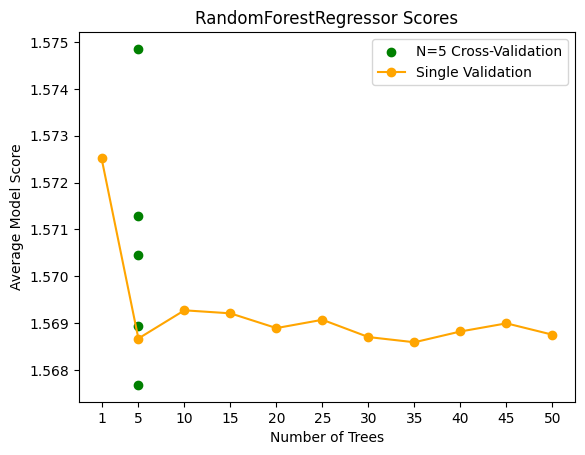

In [14]:
plt.scatter(np.full((len(RFR_cross_val_scores),), 5),RFR_cross_val_scores,marker='o',label='N=5 Cross-Validation',color='green')
plt.plot(estimator_number,np.mean(np.array(scores), axis=1),marker='o',label='Single Validation',color='orange')
plt.xticks([int(i) for i in estimator_number])
plt.xlabel('Number of Trees')
plt.ylabel('Average Model Score')
plt.title('RandomForestRegressor Scores')
plt.legend()

In [22]:
with open('RFR_cross_val_scores_n5.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for i in range(len(np.full((len(RFR_cross_val_scores),), 5))):
        writer.writerow([np.full((len(RFR_cross_val_scores),), 5)[i], RFR_cross_val_scores[i]])
    print('Scores saved to file.')

Scores saved to file.


In [20]:

estimator_n20 = MultiOutputRegressor(RandomForestRegressor(n_estimators=20, random_state=117, verbose=1))
RFR_cross_val_scores_n20 = cross_val_score(estimator_n20, X, y, cv=5, scoring=scorer)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

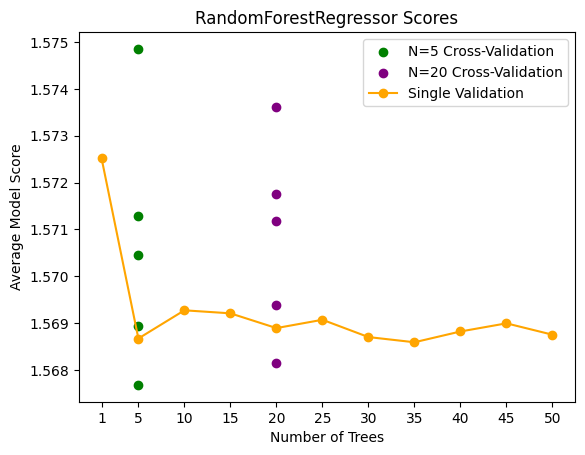

In [21]:
plt.scatter(np.full((len(RFR_cross_val_scores),), 5),RFR_cross_val_scores,marker='o',label='N=5 Cross-Validation',color='green')
plt.scatter(np.full((len(RFR_cross_val_scores_n20),), 20),RFR_cross_val_scores_n20,marker='o',label='N=20 Cross-Validation',color='purple')
plt.plot(estimator_number,np.mean(np.array(scores), axis=1),marker='o',label='Single Validation',color='orange')
plt.xticks([int(i) for i in estimator_number])
plt.xlabel('Number of Trees')
plt.ylabel('Average Model Score')
plt.title('RandomForestRegressor Scores')
plt.legend()

In [23]:
with open('RFR_cross_val_scores_n20.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for i in range(len(np.full((len(RFR_cross_val_scores_n20),), 20))):
        writer.writerow([np.full((len(RFR_cross_val_scores_n20),), 20)[i], RFR_cross_val_scores_n20[i]])
    print('Scores saved to file.')

Scores saved to file.


Text(0.5, 1.0, 'RandomForestRegressor Scores')

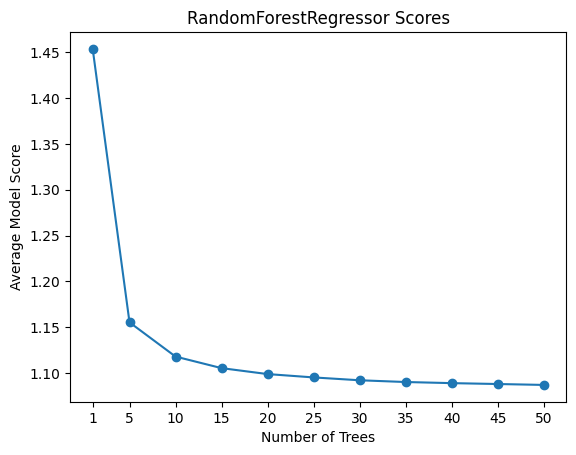

In [15]:
mae_scores = []
for model in predictions:
    mae_scores.append(mean_absolute_error( y_test, model))


plt.plot(estimator_number,mae_scores,marker='o')
plt.xticks([int(i) for i in estimator_number])
plt.xlabel('Number of Trees')
plt.ylabel('Average Model Score')
plt.title('RandomForestRegressor Scores')



In [24]:
with open('RandomForestRegressorScores_default_mae.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for i in range(len(estimator_number)):
        writer.writerow([estimator_number[i], mae_scores[i]])
    print('Scores saved to file.')


Scores saved to file.
